# Portfolio Optimization

Dado una lista de stocks, proceder a realizar la mejor alocacion posible de acuerdo a criterios:

* max Shp
* min Vol
* IVP
* EQW
* HRP
* By User (ad hoc, min drawdown, max return, max sortino)

También considerar (para benchmark) portfolios diseñados, tales como:

* Blue Chip
* W Buffet (BRKB)
* Wood
* Burry
* Wells Fargo
* Managed Futures / Cartera 2022 CF

In [ ]:
# definir espacio temporal (x correlacion)
# definir sensibilidad a cambios de retorno = backtesting
# PORTABILIDAD
# no existe portfolio universal, solo particular, yaque c/u tiene distintas aversiones al risk

****
## OPTIMIZACION

In [1]:
import numpy as np, pandas as pd, seaborn as sns
import random, requests

from matplotlib import pyplot as plt
from scipy import stats

#import yfinance as yf

import cvxopt as opt
#from scipy import optimize
import scipy.cluster.hierarchy as sch

from scipy.optimize import Bounds, LinearConstraint, minimize

#tickers= ['SQM','ALB','LTHM','LAC','PLL'] # (5 stocks para jugar al Litio,CF, May 2021)
tickers=['WFC','BXP','RTX','ERJ','NXE','XLE','RSX','XME'] # Mineras de Plata,Oro, Platino (CF, May 2021)
#tickers=['EDU','ITB','ROM','BIB','KRE','CHIX','KWEB','OIH','SU','FXI','KSTR'] # Steve_march
#tickers=['EDU','ITB','ROM','BIB']

In [2]:
def getPrice(symbol):
    """
    Historical Daily Prices
    Dado un activo (symbol), retorna unicamente su closing price historico (máx 40 years)
    Return: daily dataframe (close)
    """        
    try:
        url='https://financialmodelingprep.com/api/v3/historical-price-full/'+symbol
        api_key='bb2325e9fc32528d8472b3d75d1bd41c'
        p= {'serietype' : 'line','apikey': api_key}
        r=requests.get(url,params=p)
        js=r.json()
        df=pd.DataFrame(js['historical'])
        df.set_index('date',inplace=True)
        df.index=pd.to_datetime(df.index)
        df.rename(columns={'close':'price'},inplace=True)
        df.sort_values('date',ascending=True, inplace=True)
        return df

    except:
        print(symbol,' Historical daily prices not found')

In [6]:
# TOMO 5 (171) metodo alternativo de construccion de df
lista=[]
for stock in tickers:
    lista.append(getPrice(stock))
data=pd.concat(lista,axis=1)
data.columns=tickers

In [7]:
# def calculos
retorno = data.pct_change() # idem b[1:]/b[:-1]-1
volatilidad = retorno.rolling(250).std() * 250**0.5
drawdown =(retorno+1).cumprod() / (retorno+1).cumprod().cummax()-1
cagr=((retorno+1).cumprod()-1)

In [8]:
#rets = np.log((data/data.shift(1))) # alternativamente rets=data.pct_change().dropna()
#vol=rets.rolling(250).std()*250**0.5 # rets.std()*250**0.5
#dd=-qs.stats.to_drawdown_series(data)

r = np.mean(retorno,axis=0)*250
covar = retorno.cov()
corr=retorno.corr()

In [9]:
def ret(r,w):
    return r.dot(w)
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))
def sharpe (ret,vol):
    return ret/vol

In [10]:
bounds = Bounds(0, 1)
linear_constraint = LinearConstraint(np.ones((retorno.shape[1],), dtype=int),1,1)

weights = np.ones(retorno.shape[1])
x0 = weights/np.sum(weights)

# minimum risk portfolio
fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
res = minimize(fun1,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)
w_min = res.x # weights with the lowest level of risk possible
np.set_printoptions(suppress = True, precision=2)
#print('\n Min Risk return: % .2f'% (ret(r,w_min)*100), 'risk: % .3f'% vol(w_min,covar))
#print(w_min)

# maximum sharpe
fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)
w_sharpe = res_sharpe.x # weights with the highest Sharpe ratio
#print('\n Max Sharpe return: % .2f'% (ret(r,w_sharpe)*100), 'risk: % .3f'% vol(w_sharpe,covar))
#print(w_sharpe)

# maximum volatility
fun3 = lambda w: -np.sqrt(np.dot(w,np.dot(w,covar)))
max_vol = minimize(fun3,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)
w_max = max_vol.x # weights with max volatility
#print('\n Max Volatility return: % .2f'% (ret(r,w_max)*100), 'risk: % .3f'% vol(w_max,covar))
#print(w_max)

# maximum return
fun4 = lambda w: -r.dot(w)
res_max = minimize(fun3,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)
w_max_ret = res_max.x # weights with max return
#print('\n Max Risk return: % .2f'% (ret(r,w_max_ret)*100), 'risk: % .3f'% vol(w_max_ret,covar))
#print(w_max_ret)

In [11]:
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getEQW(cov):
    # Compute the equal weights portfolio
    return [1 / len(cov) for i in range(len(cov))]      

In [12]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [18]:
def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, "single")
    dn = sch.dendrogram(link, labels=cov.index.values)
    plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

def plotCorrMatrix(corr,labels=None):
    # Heatmap of the correlation matrix
    if labels is None:labels=[]
    plt.pcolor(corr)
    plt.colorbar()
    plt.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    #plt.savefig(path)
    plt.clf();plt.close
    return    

C:\Users\Usuario\AppData\Local\Temp/ipykernel_5400/884457573.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist, "single")


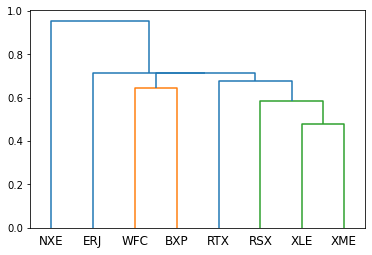


HRP BXP    0.168435
ERJ    0.122123
NXE    0.044305
RSX    0.084068
RTX    0.197881
WFC    0.152949
XLE    0.149267
XME    0.080972
dtype: float64

IVP [0.15 0.16 0.2  0.08 0.03 0.19 0.09 0.1 ]

EQW [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]


In [19]:
hrp=getHRP(covar,corr)
ivp=getIVP(covar)
eqw=getEQW(covar)
print('\nHRP',hrp)
print('\nIVP',ivp)
print('\nEQW',eqw)

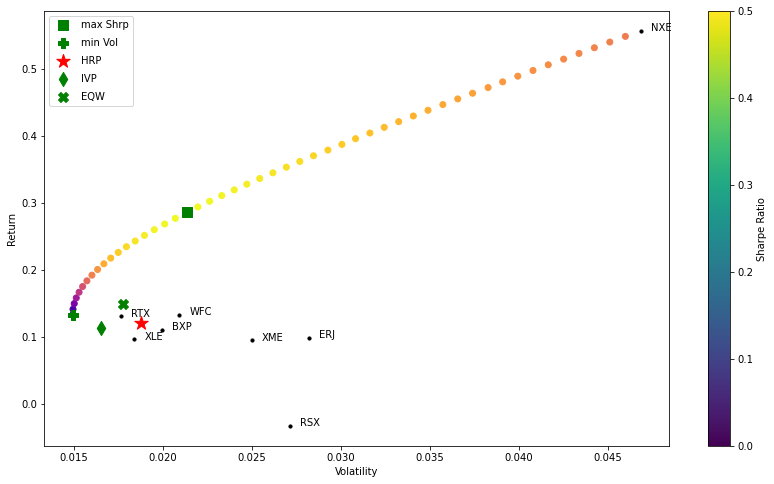

In [16]:
w = w_min
num_ports = 50
gap = (np.amax(r) - ret(r,w_min))/num_ports
all_weights = np.zeros((num_ports, len(retorno.columns)))
all_weights[0],all_weights[1]=w_min,w_sharpe
ret_arr = np.zeros(num_ports)
ret_arr[0],ret_arr[1]=ret(r,w_min),ret(r,w_sharpe)
vol_arr = np.zeros(num_ports)
vol_arr[0],vol_arr[1]=vol(w_min,covar),vol(w_sharpe,covar)

for i in range(num_ports):
    port_ret = ret(r,w) + i*gap
    double_constraint = LinearConstraint([np.ones(retorno.shape[1]),r],[1,port_ret],[1,port_ret])
    
    #Create x0: initial guesses for weights.
    x0 = w_min
    #Define a function for portfolio volatility.
    fun = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
    a = minimize(fun,x0,method='trust-constr',constraints = double_constraint,bounds = bounds)
    
    all_weights[i,:]=a.x
    ret_arr[i]=port_ret
    vol_arr[i]=vol(a.x,covar)
 
plt.figure(figsize=(14,8))
plt.scatter(vol_arr, ret_arr, c=ret_arr/vol_arr, cmap='plasma') 

plt.scatter(vol(w_sharpe,covar),ret(r,w_sharpe),marker='s',s=100,color='g',label='max Shrp')
plt.scatter(vol(w_min,covar),ret(r,w_min),marker='P',s=100,color='g',label='min Vol')
plt.scatter(vol(hrp,covar),ret(r,hrp),marker='*',s=200,color='r',label='HRP')
plt.scatter(vol(ivp,covar),ret(r,ivp),marker='d',s=100,color='g',label='IVP')
plt.scatter(vol(eqw,covar),ret(r,eqw),marker='X',s=100,color='g',label='EQW')

marca=np.identity(len(tickers))
for i in range(len(tickers)):
    plt.scatter(vol(marca[i],covar),ret(r,marca[i]),marker='o',s=10,color='k')
    plt.annotate(tickers[i],(vol(marca[i],covar),ret(r,marca[i])), xytext=(10,0), textcoords='offset points')

plt.colorbar(label='Sharpe Ratio')
plt.clim(0,0.5)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.show()

In [17]:
allocations={'EQW':eqw,'Min Vol':w_min,'IVP':ivp,'Max Sharpe':w_sharpe,'HRP':hrp}
df_alloc=pd.DataFrame(allocations)

df=pd.DataFrame(index=['retorno','volatilidad','Sharpe'],columns=allocations.keys())
df=pd.concat([df,df_alloc])

for estrategia in allocations.keys():

    w=allocations.get(estrategia)
    df.loc['retorno'][estrategia]=r.dot(w)
    df.loc['volatilidad'][estrategia]=np.sqrt(np.dot(w,np.dot(w,covar)))
    df.loc['Sharpe'][estrategia]=df.loc['retorno'][estrategia]/df.loc['volatilidad'][estrategia]
    #df.loc['Sortino'][estrategia]=qs.stats.sortino(new_rets)
    #df.loc['drawdown'][estrategia]=qs.stats.max_drawdown(new_data)

df.round(3)

,EQW,Min Vol,IVP,Max Sharpe,HRP
retorno,0.148,0.132,0.113,0.286,0.121
volatilidad,0.018,0.015,0.017,0.021,0.019
Sharpe,8.351,8.865,6.832,13.368,6.417
BXP,0.125,0.146,0.146,0.244,0.168
ERJ,0.125,0.168,0.161,0.002,0.122
NXE,0.125,0.411,0.205,0.391,0.044
RSX,0.125,0.000,0.080,0.000,0.084
RTX,0.125,0.032,0.029,0.363,0.198
WFC,0.125,0.243,0.189,0.000,0.153
XLE,0.125,0.000,0.087,0.000,0.149


****
## CORRELACION

### 1.Definir variable de interes

* Retorno

* Volatilidad (Taleb utiliza 3 months correlation annual)

* Drawdown

* CAGR 

### 2.Análisis exploratorio

### 3.Segmentación

### 4.Definir view

In [16]:
def define(a=1):
    if a==1:
        var_int=retorno
        titulo='retorno'
    elif a==2:
        var_int=volatilidad
        titulo='volatilidad'
    elif a==3:
        var_int=drawdown
        titulo='drawdown'
    else:
        var_int=cagr
        titulo='cagr'
    return var_int,titulo

In [45]:
# Define variable de interes

var_int, titulo=define(3)

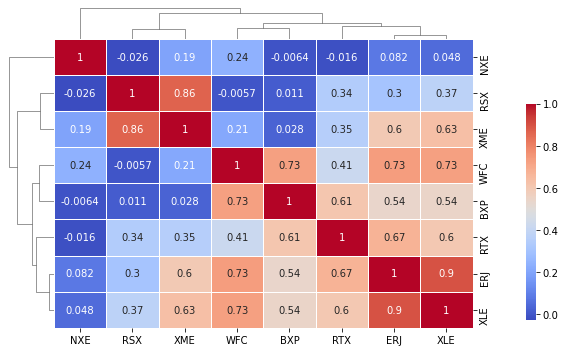

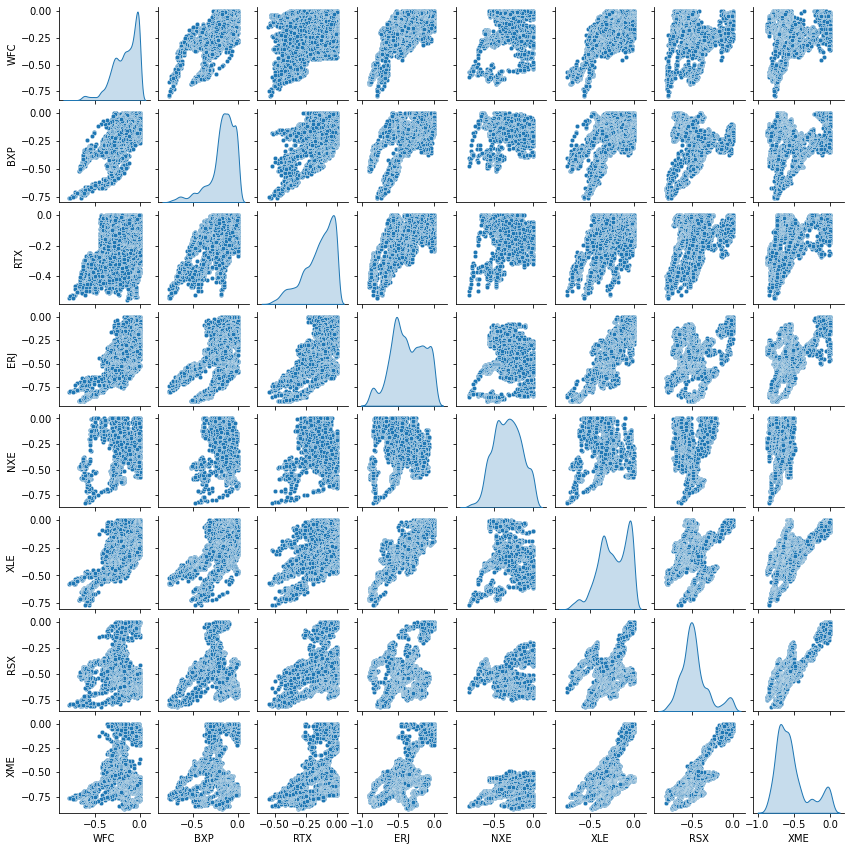

In [46]:
matriz=var_int.corr()
sns.clustermap(matriz,cmap='coolwarm',dendrogram_ratio=(.1,.1),cbar_pos=(1.05,.1,.02,.6),linewidths=1,figsize=(7,5),annot=True)
sns.pairplot(var_int,diag_kind='kde',plot_kws={'s':20},height=1.5)

In [47]:
# Define pares a estudiar - maxima y minima correlacion

np.fill_diagonal(matriz.values, np.nan)

min_uno=matriz.stack().idxmin()[0]
min_dos=matriz.stack().idxmin()[1]
min_val=matriz.stack().min()
print('Pares de correlacion minima ',min_uno,min_dos,' = ',min_val)

max_uno=matriz.stack().idxmax()[0]
max_dos=matriz.stack().idxmax()[1]
max_val=matriz.stack().max()
print('Pares de correlacion maxima ',max_uno,max_dos,' = ',max_val)

Pares de correlacion minima  NXE RSX  =  -0.02596906091188145
Pares de correlacion maxima  ERJ XLE  =  0.8994667338514262


In [48]:
# Define pares ad hoc a estudiar como alternativa exploratoria

#max_uno='SU'
#max_dos='FXI'
#min_uno='BIB'
#min_dos='ITB'

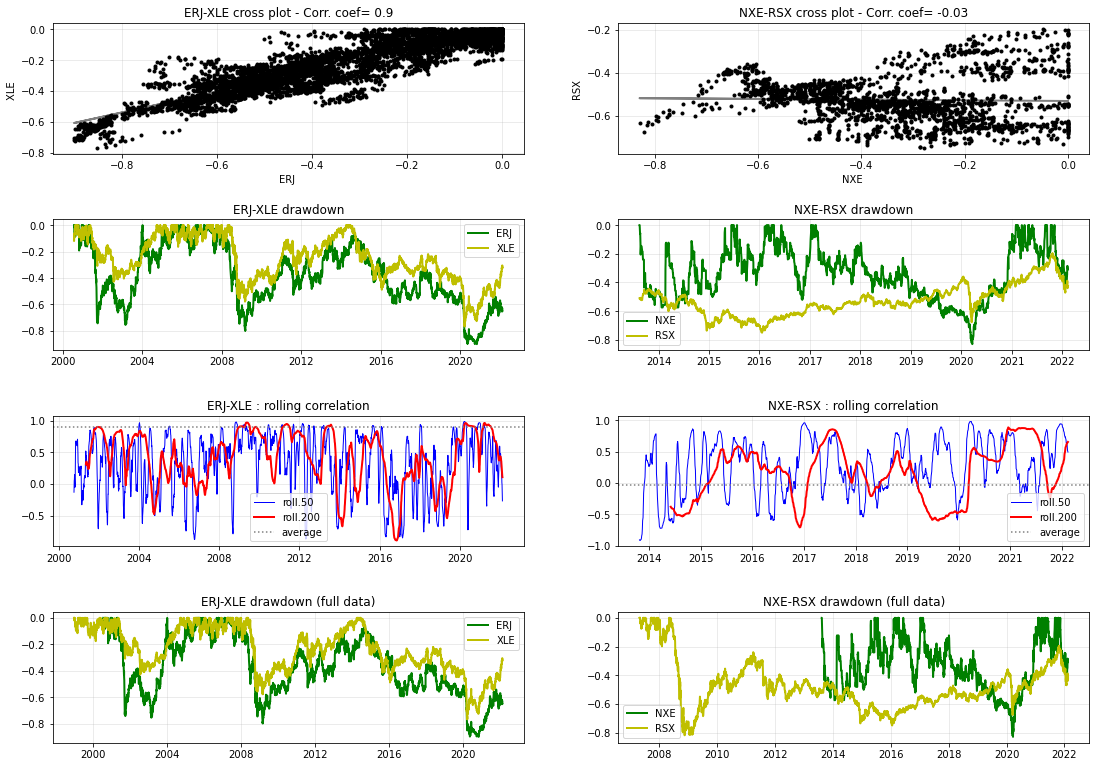

In [49]:
# PLOT 2

fig,ax =plt.subplots(figsize=(16,10),nrows=4,ncols=2)
fig.subplots_adjust(hspace=0.5,left=0.05, right=0.95, bottom=0.05, top=1.05)

recta_max=pd.concat([var_int[max_uno],var_int[max_dos]],axis=1).dropna()
m, b = np.polyfit(recta_max[max_uno],recta_max[max_dos] , 1)
ax[0][0].plot(recta_max[max_uno], m*recta_max[max_uno]+b, color='grey',linewidth=2)
ax[0][0].title.set_text(max_uno + '-'+ max_dos + ' cross plot - Corr. coef= ' + str(round(np.corrcoef(recta_max[max_uno], recta_max[max_dos])[0,1],2)))
ax[0][0].plot(var_int[max_uno],var_int[max_dos], 'o', color='black',markersize=3)
ax[0][0].grid('True',alpha=0.3)
ax[0][0].set_xlabel(max_uno + ' ')
ax[0][0].set_ylabel(max_dos + ' ')

recta_min=pd.concat([var_int[min_uno],var_int[min_dos]],axis=1).dropna()
m, b = np.polyfit(recta_min[min_uno],recta_min[min_dos] , 1)
ax[0][1].plot(recta_min[min_uno], m*recta_min[min_uno]+b, color='grey',linewidth=2)
ax[0][1].title.set_text(min_uno + '-'+ min_dos + ' cross plot - Corr. coef= ' + str(round(np.corrcoef(recta_min[min_uno], recta_min[min_dos])[0,1],2)))
ax[0][1].plot(var_int[min_uno],var_int[min_dos], 'o', color='black',markersize=3)
ax[0][1].grid('True',alpha=0.3)
ax[0][1].set_xlabel(min_uno + ' ')
ax[0][1].set_ylabel(min_dos + ' ')

ax[1][0].title.set_text(max_uno + '-'+ max_dos + ' ' + titulo)
ax[1][0].grid('True',alpha=0.3)
ax[1][0].plot(recta_max[max_uno],label=max_uno,c='g',lw=2)
ax[1][0].plot(recta_max[max_dos],label=max_dos,c='y',lw=2)
ax[1][0].legend()

ax[1][1].title.set_text(min_uno + '-'+ min_dos + ' ' + titulo)
ax[1][1].grid('True',alpha=0.3)
ax[1][1].plot(recta_min[min_uno],label=min_uno,c='g',lw=2)
ax[1][1].plot(recta_min[min_dos],label=min_dos,c='y',lw=2)
ax[1][1].legend()

ax[2][0].title.set_text(max_uno + '-'+ max_dos + ' : rolling correlation')
ax[2][0].grid('True',alpha=0.3)
ax[2][0].plot(var_int[max_uno].rolling(50).corr(var_int[max_dos]),label='roll.50',c='b',lw=1)
ax[2][0].plot(var_int[max_uno].rolling(200).corr(var_int[max_dos]),label='roll.200',c='r',lw=2)
ax[2][0].axhline(y=var_int[max_uno].corr(var_int[max_dos]).mean(),label='average',ls='dotted',color='grey')
ax[2][0].legend()

ax[2][1].title.set_text(min_uno + '-'+ min_dos + ' : rolling correlation')
ax[2][1].grid('True',alpha=0.3)
ax[2][1].plot(var_int[min_uno].rolling(50).corr(var_int[min_dos]),label='roll.50',c='b',lw=1)
ax[2][1].plot(var_int[min_uno].rolling(200).corr(var_int[min_dos]),label='roll.200',c='r',lw=2)
ax[2][1].axhline(y=var_int[min_uno].corr(var_int[min_dos]).mean(),label='average',ls='dotted',color='grey')
ax[2][1].legend()

ax[3][0].title.set_text(max_uno + '-'+ max_dos + ' ' + titulo +' (full data)')
ax[3][0].grid('True',alpha=0.3)
ax[3][0].plot(var_int[max_uno],label=max_uno,c='g',lw=2)
ax[3][0].plot(var_int[max_dos],label=max_dos,c='y',lw=2)
ax[3][0].legend()

ax[3][1].title.set_text(min_uno + '-'+ min_dos + ' ' + titulo + ' (full data)')
ax[3][1].grid('True',alpha=0.3)
ax[3][1].plot(var_int[min_uno],label=min_uno,c='g',lw=2)
ax[3][1].plot(var_int[min_dos],label=min_dos,c='y',lw=2)
ax[3][1].legend()

plt.show()

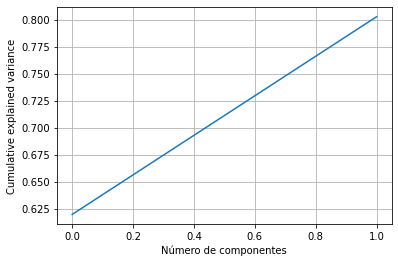

In [22]:
# PCA para detección de variables redundantes

from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(var_int.dropna().to_numpy())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

****
## BACKTESTING


Considerar el modelado de retornos (KdE: volatilildad, correlaciones, drawdown...) para calcular luego vía MC los parámetros del portfolio (retorno, volatilidad, Sharpe, Sortino) con muestras out of the sample.


Considerar el modelado de retornos via Normal + shock (como alternativo a lo anterior)

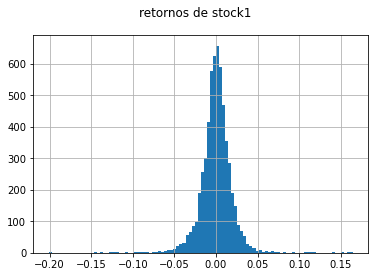

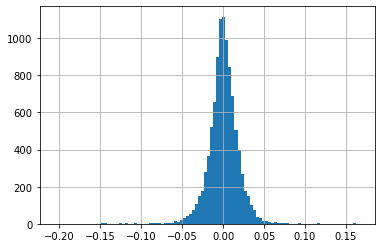

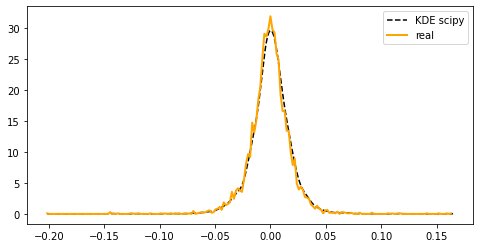

In [23]:
stock1= data.XLE
ret1=stock1.pct_change().dropna()
#volat=((stock1.pct_change()*100).rolling(250).std()*250**0.5).dropna()
ret1.hist(bins=100,figsize=(6,4))
plt.suptitle('retornos de stock1')
plt.show()
kde=stats.gaussian_kde(ret1)
resampleo=kde.resample(size=10000)[0]
pd.Series(resampleo).hist(bins=100)
x_eval=np.linspace(min(ret1),max(ret1),len(ret1))
fig,ax=plt.subplots(figsize=(8,4))
kde=stats.gaussian_kde(ret1)
ax.plot(x_eval,kde(x_eval),'k--',label='KDE scipy')
count,division=np.histogram(ret1,density=True,bins=200)
ax.plot(division[:-1],count,lw=2,color='orange',label='real')
ax.legend()

****
****
# ANEXO
****
****

****
## PORTFOLIOS

tickers = ['EDU','ITB','ROM','BIB','KRE','CHIX','KWEB','OIH','SU','FXI','KSTR'] # Steve_march

tickers = ['AAPL','FB','KO','AMZN','XOM','BA','GOOG','GE','WFC','GLD','SLV','NFLX']

tickers = ['AAPL','FB','AMZN','GOOG','NFLX']

tickers = ['GOOG','AMZN','XOM']

Wells Fargo

https://www.morganstanley.com/im/en-hk/intermediary-investor/funds-and-performance/morgan-stanley-investment-funds/equity/us-growth.html

CUSIP:L65235308 (este CUSIP ameritrade NO LO RECONOCE) - ISIN: LU0073232471

****
## HRP Explanation

(Check A+Modern+Guide+to+Portfolio+Optimization.pdf)


<img src='hrp.jpg' width='300'>

****
## WEB SITES

Python Data Science

Python for Data Science eDx

https://alpaca.markets/learn/correlation-portfolio-python/

****
## PLOTS

In [ ]:
#sns.heatmap(matriz,cmap='coolwarm',linewidths=1,annot=True)

#plt.figure(figsize=(4, 6))
#heatmap = sns.heatmap(drawdown.corr()[['LTHM']].sort_values(by='LTHM', ascending=False), vmin=-1, vmax=1, annot=True, cmap='vlag')
#heatmap.set_title('Drawdown') # VALIDA los calculos 

# sns.distplot(drawdown['LTHM'].rolling(50).corr(drawdown['SQM']), rug=True, hist=True,bins=50)
# sns.distplot(drawdown['LTHM'].rolling(200).corr(drawdown['SQM']), rug=True, hist=True,bins=50)

#with sns.axes_style('white'):
#    sns.jointplot(x=drawdown['ITB'],y=drawdown['ROM'], kind='kde');

#sns.jointplot(x=drawdown['ITB'],y=drawdown['ROM'],kind='reg')

#heatmap = sns.heatmap(drawdown, vmin=-1, vmax=1, annot=True, cmap='vlag') # TODO el HEAT MAP correlacionado con date
#sns.clustermap(retorno.dropna(),cmap='vlag',dendrogram_ratio=(.1,.3),cbar_pos=(1.05,.1,.02,.6),linewidths=1,figsize=(10,8)) # SAME ahora con DENDOGRAM

#plt.hist(retorno['ROM'].rolling(250).corr(retorno['ITB']).dropna(),bins=200,density=True)

#from warnings import filterwarnings
#filterwarnings ('ignore')
#sns.jointplot(x=drawdown[max_uno],y=drawdown[max_dos],kind='reg').annotate(stats.pearsonr)
#sns.jointplot(x=drawdown[min_uno],y=drawdown[min_dos],kind='reg').annotate(stats.pearsonr)

****
## QUANTSTATS

* calculo de sortino difiere
* calculo de sharpe confirma

In [ ]:
import quantstats as qs

#qs.extend_pandas()
#[f for f in dir(qs.plots) if f[0] != '_']
#[f for f in dir(qs.stats) if f[0] != '_']

In [ ]:
tickers=['AAPL','AMZN','FB','GOOGL','NFLX']

data_port=yf.download(tickers,start='2013-01-01',auto_adjust=True)
#data_bench=yf.download('SQQQ',start='2013-01-01',auto_adjust=True)
#data_stock=yf.download('FB',start='2013-01-01',auto_adjust=True)

#returns_bench=data_bench.Close.pct_change().dropna()
#returns_stock=data_stock.Close.pct_change().dropna()

[*********************100%***********************]  5 of 5 completed


In [ ]:
#qs.plots.snapshot(data_stock.Close, title='Facebook Performance')
#qs.plots.returns(data_stock.Close,data_bench.Close)
#qs.plots.rolling_sharpe(data_stock.Close)
#qs.plots.drawdown(data_stock.Close)
#qs.plots.rolling_volatility(data_stock.Close)
#qs.reports.plots(returns_stock)

In [ ]:
# REPORTE
#qs.reports.basic(returns_stock,figsize=(7,3))
#qs.reports.metrics(returns_stock)

In [ ]:
#qs.reports.basic(returns_stock,returns_bench,figsize=(7,3))

In [ ]:
w_original={'AAPL':0.1,'AMZN':0.1,'FB':0.6,'GOOGL':0.1,'NFLX':0.1}
weights_original=np.array(list(w_original.values()))

returns_original=data_port.Close.pct_change().dropna()
returns_original=(returns_original*weights_original).sum(axis=1)

print('CAGR',qs.stats.cagr(returns_original))

price_port_original=data_port.Close*w_original
price_port_original['Total'] = price_port_original.sum(axis=1)

print('DD max',qs.stats.max_drawdown(price_port_original.Total))

CAGR 0.3621315983081277
DD max -0.3114413620526325


In [ ]:
lista=[]
for p in range(10):
    weights_optimo=np.random.random(len(w_original))
    weights_optimo /= np.sum(weights_optimo)

    price_port_optimo=data_port.Close*weights_optimo
    price_port_optimo['Total'] = price_port_optimo.sum(axis=1)
    
    res={'weights optimo':weights_optimo,'Max DD':qs.stats.max_drawdown(price_port_optimo.Total)}
    lista.append(res)

df=pd.DataFrame(lista)

In [ ]:
#returns_optimo=data_port.Close.pct_change().dropna()
#returns_optimo=(returns_optimo*best['weights optimo']).sum(axis=1)

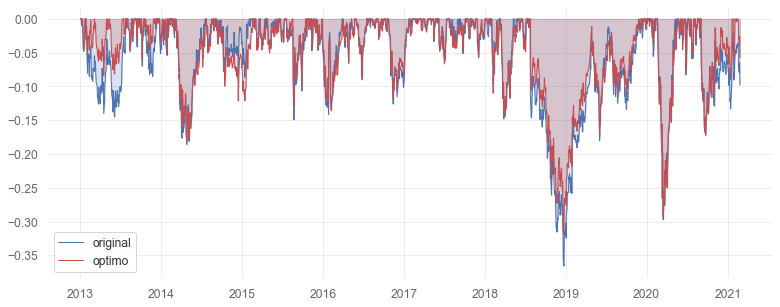

In [ ]:
fig,ax=plt.subplots(figsize=(13,5))

original_dd=(returns_original+1).cumprod() / (returns_original+1).cumprod().cummax()-1
optimo_dd=(returns_optimo+1).cumprod() / (returns_optimo+1).cumprod().cummax()-1

ax.plot(original_dd,lw=1,color='b',label='original')
ax.fill_between(original_dd.index,original_dd,alpha=0.2,color='b')

ax.plot(optimo_dd,lw=1,color='r',label='optimo')
ax.fill_between(optimo_dd.index,optimo_dd,alpha=0.2,color='r')

ax.legend()

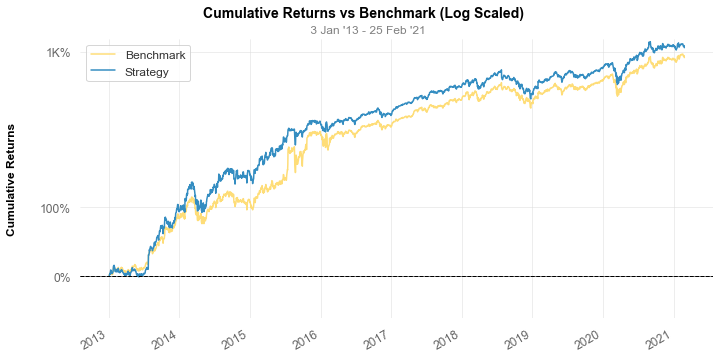

In [ ]:
qs.plots.log_returns(returns_original,returns_optimo,match_volatility=False)

In [ ]:
print('CAGR original',qs.stats.cagr(returns_original))
print('CAGR optimo',qs.stats.cagr(returns_optimo))

print('DD max original',qs.stats.max_drawdown(price_port_original.Total))
print('DD max optimo',qs.stats.max_drawdown(price_port_optimo.Total))

CAGR original 0.3531075376732602
CAGR optimo 0.32564309153791204
DD max original -0.3114413620526325
DD max optimo -0.2915577175883066


****
## SORTINO

In [ ]:
rendimientos=rets.mean()
desvios=rets.std()
tasaRF=0.0

tablaRatios=pd.DataFrame(index=rets.columns)
tablaRatios['sharpeDiario']=(rendimientos-tasaRF)/desvios
tablaRatios['sharpeAnualizado']=tablaRatios.sharpeDiario*250**0.5

sortinos=[]

for activo in tickers:
    
    filtro=rets[activo].loc[rets[activo]<0]
    desvioNeg=filtro.std()
    sortinos.append((rendimientos[activo]-tasaRF)/desvioNeg)
    
tablaRatios['sortinoDiario']=sortinos
tablaRatios['sortinoAnualizado']=tablaRatios.sortinoDiario*252**0.5
print('\n',tablaRatios)

****
## MVP (Financial Analytics)

In [ ]:
def getMVP(cov):
    '''
    Markowitz’s Minimum-Variance Portfolio (MVP)
    
    '''
    import warnings
    warnings.simplefilter('ignore', np.RankWarning)
    opt.solvers.options['show_progress'] = False # evita las salidas intermedias
    
    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [opt.solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [opt.blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(opt.blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = opt.solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

****
## TABULA

WARNING: The script distro.exe is installed in 'C:\Users\sliwinsl\AppData\Roaming\Python\Python38\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Successfully installed distro-1.5.0 tabula-py-2.2.0

In [ ]:
import os, tabula

In [ ]:
path='C:\\Users\\sliwinsl\\Dataset\\Data_3'
os.chdir(path)
print(os.getcwd())

C:\Users\sliwinsl\Dataset\Data_3


In [ ]:
#tabula.read_pdf('steve_march.pdf',pages='1')